In [6]:
import os
import numpy as np
import allel
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gffutils

In [7]:
os.chdir('/mnt/storage11/sophie/darlingi/holly_wgs_paper')
os.getcwd()

'/mnt/storage11/sophie/darlingi/holly_wgs_paper'

In [8]:
# convert phased, filtered, VCF file to zarr file
# already converted to zarr
#allel.vcf_to_zarr('2019melasglobal_finalfiltered_gambiaealigned_phased.vcf.gz', '2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', fields='*', overwrite=True)

In [9]:
callset = zarr.open('holly_wgs_samples_darlingi_filtered_phased.zarr', mode='r')
#callset.tree(expand=True)

In [10]:
## convert zarr file to genotype array
gt = allel.GenotypeDaskArray(callset['calldata/GT'])
print(gt.shape)

(1539646, 28, 2)


In [11]:
## import metadata
df_samples=pd.read_csv('/mnt/storage11/sophie/darlingi/holly_wgs_paper_metadatav2.csv',sep=',',usecols=['sample','population'])
df_samples.head()
df_samples.groupby(by=['population']).count

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f7c59f87af0>>

In [12]:
## VCF is phased so we can convert genotype arrays made earlier to haplotype array

sample_ids = callset['samples'][:]

In [13]:
# Get sample identifiers for Rondonia samples from df_samples
Rondonia_sample_ids = df_samples[df_samples['population'] == 'Rondonia_State']['sample'].values
# Find indices of these samples in the genotype array
Rondonia_indices = np.array([np.where(sample_ids == id)[0][0] for id in Rondonia_sample_ids if id in sample_ids])
# Verify the indices are within the correct range
print("Max index:", Rondonia_indices.max(), "Sample array size:", len(sample_ids))
# Select genotypes for Rondonia samples using the indices
gt_Rondonia_samples = gt.take(Rondonia_indices, axis=1)

Max index: 27 Sample array size: 28


In [14]:
# Get sample identifiers for Colony samples from df_samples
Colony_sample_ids = df_samples[df_samples['population'] == 'Colony_old']['sample'].values
# Find indices of these samples in the genotype array
Colony_indices = np.array([np.where(sample_ids == id)[0][0] for id in Colony_sample_ids if id in sample_ids])
# Verify the indices are within the correct range
print("Max index:", Colony_indices.max(), "Sample array size:", len(sample_ids))
# Select genotypes for Colony samples using the indices
gt_Colony_samples = gt.take(Colony_indices, axis=1)

Max index: 10 Sample array size: 28


In [15]:
h_array_Rondonia = gt_Rondonia_samples.to_haplotypes().compute()
h_array_Rondonia

h_array_Colony = gt_Colony_samples.to_haplotypes().compute()
h_array_Colony

<HaplotypeArray shape=(1539646, 16) dtype=int8>
0 0 0 0 0 ... 1 0 0 0 0
0 0 0 0 0 ... 1 0 0 0 1
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
1 1 1 1 1 ... 1 1 1 1 1

In [16]:
pos = callset['variants/POS'][:]
chrom = callset['variants/CHROM'][:]

In [17]:
# xpehh_raw = allel.xpehh(h_sus, h_res, pos, map_pos=None, min_ehh=0.05, include_edges=False, gap_scale=20000, max_gap=20000, is_accessible=None, use_threads=True)
xpehh_raw = allel.xpehh(h_array_Colony, h_array_Rondonia, pos, use_threads=True)
xpehh_raw

array([nan, nan, nan, ..., nan, nan, nan])

In [18]:
xpehh_hit_max = np.nanargmax(xpehh_raw)
xpehh_hit_max

198476

In [19]:
pos[xpehh_hit_max]

18507675

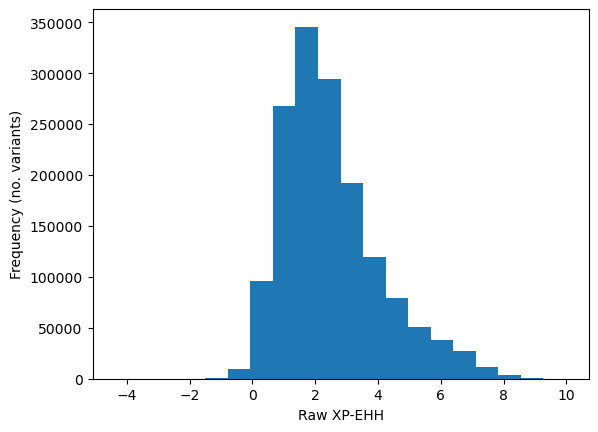

In [20]:
fig, ax = plt.subplots()
ax.hist(xpehh_raw[~np.isnan(xpehh_raw)], bins=20)
ax.set_xlabel('Raw XP-EHH')
ax.set_ylabel('Frequency (no. variants)');

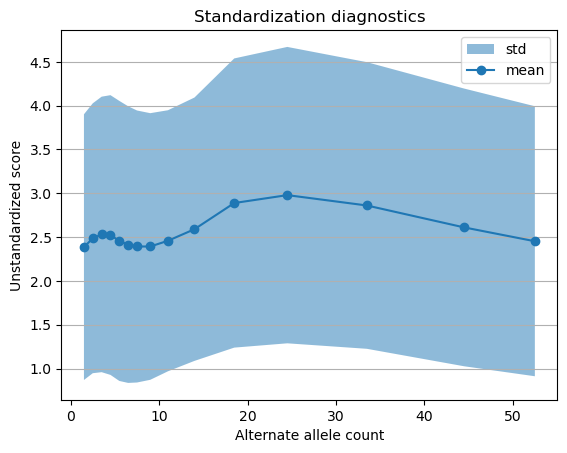

In [21]:
allele_counts_array = gt.count_alleles(max_allele=3).compute()
xpehh_std = allel.standardize_by_allele_count(xpehh_raw, allele_counts_array[:, 1])

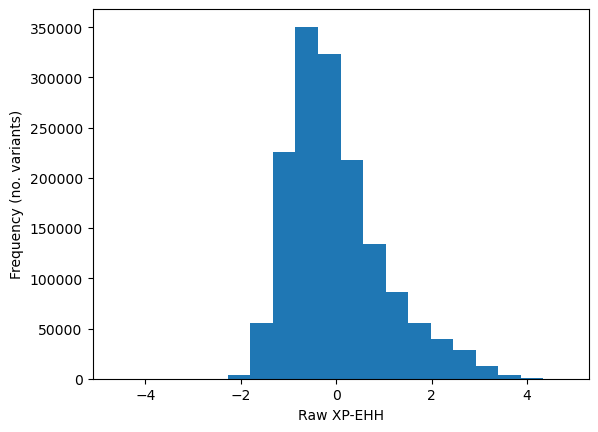

In [22]:
fig, ax = plt.subplots()
ax.hist(xpehh_std[0][~np.isnan(xpehh_std[0])], bins=20)
ax.set_xlabel('Raw XP-EHH')
ax.set_ylabel('Frequency (no. variants)');

In [23]:
# define chromosome lengths and colours 
chromosome_lengths = {
    '2': 94951917,
    '3': 71270736,
    'anop_mito': 15395,
    'anop_X': 13401267
}

# Calculate cumulative offsets for each chromosome
cumulative_lengths = {}
cumulative_length = 0
for chrom, length in chromosome_lengths.items():
    cumulative_lengths[chrom] = cumulative_length
    cumulative_length += length

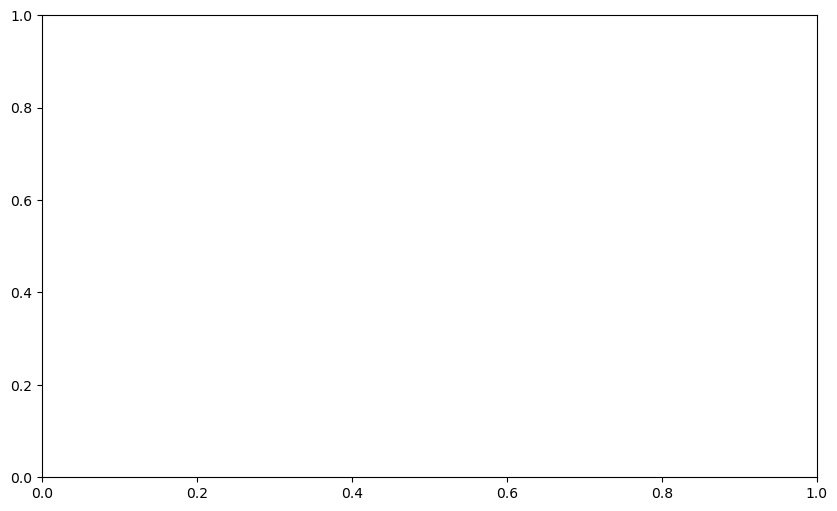

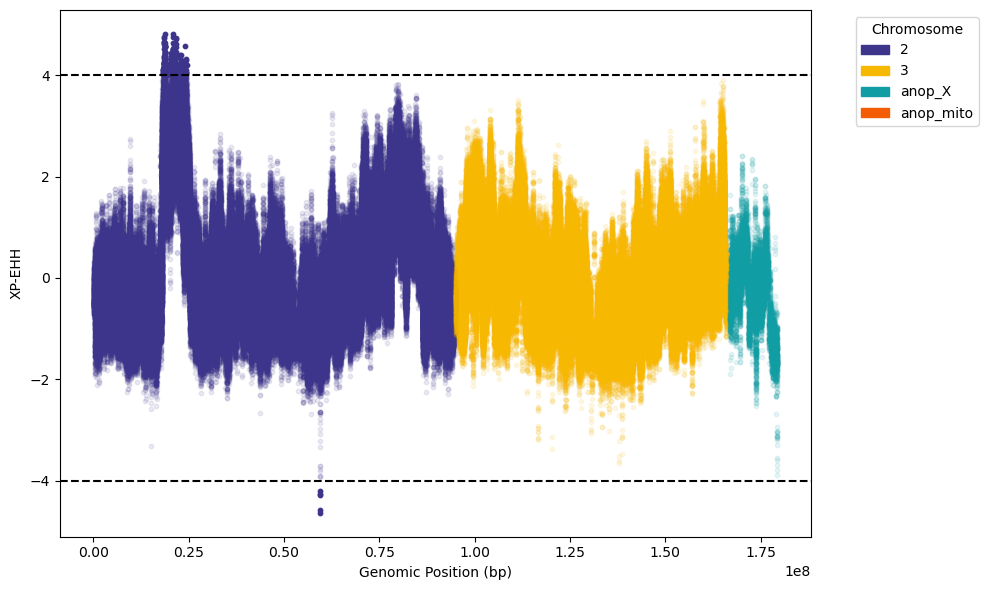

In [24]:
# Set threshold
Colony_threshold = 4
Rondonia_threshold = -4

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure that pos, chrom, and xpehh_std are all numpy arrays to support advanced indexing
pos = np.array(callset['variants/POS'][:])
chrom = np.array(callset['variants/CHROM'][:])
xpehh_standardised_values = np.array(xpehh_std[0])

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each chromosome (for illustration)
chromosome_colours = {
    '2': '#3d348b', '3': '#f7b801', 'anop_mito': '#f35b04', 'anop_X': '#119DA4'
}

# Create a list to hold the legend patches
legend_patches = []

# Filtered chromosomes list, assuming cumulative_lengths are defined for these
filtered_chroms = ['2', '3', 'anop_X', 'anop_mito']

# Iterate through each chromosome to plot its variants
for unique_chrom in filtered_chroms:
    chrom_mask = chrom == unique_chrom
    
    chrom_positions = pos[chrom_mask]
    chrom_xpehh_values = xpehh_standardised_values[chrom_mask]
    
    non_nan_mask = ~np.isnan(chrom_xpehh_values)
    chrom_positions_no_nan = chrom_positions[non_nan_mask]
    chrom_xpehh_values_no_nan = chrom_xpehh_values[non_nan_mask]
    
    adjusted_positions = chrom_positions_no_nan + cumulative_lengths.get(unique_chrom, 0)

    # Conditions for plotting
    solid_mask = (chrom_xpehh_values_no_nan >= Colony_threshold) | (chrom_xpehh_values_no_nan <= Rondonia_threshold)
    faded_mask = ~solid_mask
    
    # Plot solid points for values above 5 or below -5
    ax.scatter(adjusted_positions[solid_mask], 
               chrom_xpehh_values_no_nan[solid_mask], 
               color=chromosome_colours[unique_chrom], alpha=1.0, s=10)
    
    # Plot faded points for other values
    ax.scatter(adjusted_positions[faded_mask], 
               chrom_xpehh_values_no_nan[faded_mask], 
               color=chromosome_colours[unique_chrom], alpha=0.1, s=10)
    
    # Add patch for the legend
    patch = mpatches.Patch(color=chromosome_colours[unique_chrom], label=unique_chrom)
    legend_patches.append(patch)

# Add significance threshold lines and legend
ax.axhline(y=Colony_threshold, color='black', linestyle='--', label='Colony Threshold')
ax.axhline(y=Rondonia_threshold, color='black', linestyle='--', label='Rondonia Threshold')
ax.legend(handles=legend_patches, title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set labels
ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('XP-EHH')
plt.tight_layout()
plt.savefig('Rondonia_vs_Colony_xpehh_plot_600ppi.png', dpi=600)  # Save at 600 PPI

In [25]:
Colony_threshold_mask = xpehh_standardised_values >= Colony_threshold
Rondonia_threshold_mask = xpehh_standardised_values <= Rondonia_threshold

In [26]:
Colony_significant_chrom = chrom[Colony_threshold_mask]
Colony_significant_pos = pos[Colony_threshold_mask]
Colony_significant_xpehh = xpehh_standardised_values[Colony_threshold_mask]

Rondonia_significant_chrom = chrom[Rondonia_threshold_mask]
Rondonia_significant_pos = pos[Rondonia_threshold_mask]
Rondonia_significant_xpehh = xpehh_standardised_values[Rondonia_threshold_mask]

In [27]:
Colony_significant_xpehh_data = np.column_stack((Colony_significant_chrom, Colony_significant_pos, Colony_significant_xpehh))
Rondonia_significant_xpehh_data = np.column_stack((Rondonia_significant_chrom, Rondonia_significant_pos, Rondonia_significant_xpehh))

In [28]:
df_significant_Colony_xpehh = pd.DataFrame(Colony_significant_xpehh_data, columns=['Chromosome', 'Position', 'XPEHH'])
df_significant_Rondonia_xpehh = pd.DataFrame(Rondonia_significant_xpehh_data, columns = ['Chromosome', 'Position', 'XPEHH'])

In [32]:
df_significant_Colony_xpehh.to_csv(f'df_significant_xpehh_colony_threshold_{Colony_threshold}.csv', index=False)
df_significant_Rondonia_xpehh.to_csv(f'df_significant_xpehh_rondonia_threshold_{Rondonia_threshold}.csv', index=False)

In [33]:
print("Using GFF file to bring in annotations for these positions")

# Parameters
input_file_name = f"df_significant_xpehh_colony_threshold_{Colony_threshold}.csv"
output_file_name = f"df_significant_xpehh_colony_threshold_{Colony_threshold}_annotated.csv"
gff_file = '/mnt/storage11/sophie/reference_genomes/An_darlingi_ncbi/GCF_943734745.1_idAnoDarlMG_H_01_genomic.gff'

# Function to find and format the GFF line(s) that overlap a given position
def find_overlapping_gff_lines(chromosome, position, gff_file):
    chromosome_mapping = {
        "NC_064873.1": "anop_X",
        "NC_064874.1": "2",
        "NC_064875.1": "3",
        "NC_064876.1": "anop_mito"
    }
    reverse_mapping = {v: k for k, v in chromosome_mapping.items()}
    gff_chromosome = reverse_mapping.get(chromosome)

    if not gff_chromosome:
        print(f"No mapping found for chromosome {chromosome}")
        return []

    overlapping_lines = []
    with open(gff_file, 'r') as gff:
        for line in gff:
            if line.startswith('#') or line.strip() == "":
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
            
            if parts[0] == gff_chromosome:
                start = int(parts[3])
                end = int(parts[4])
                if start <= position <= end:
                    print(f"Match found: {chromosome}:{position} in {parts[0]}:{start}-{end}")
                    annotation = parts[8]
                    formatted_line = f"{parts[0]}:{start}-{end} | {annotation}"
                    overlapping_lines.append(formatted_line)
    if not overlapping_lines:
        print(f"No overlap found for {chromosome}:{position}")
    return overlapping_lines

# Writing output file
with open(output_file_name, "w") as outfile:
    # Write the header line
    outfile.write("Chromosome\tPosition\tXPEHH Value\tGff_Annotation\n")

    with open(input_file_name, "r") as infile:
        next(infile)  # Skip the header line
        for line in infile:
            # Split the line using comma as the delimiter
            parts = line.strip().split(",")
            if len(parts) < 3:  # Ensure the line has at least three columns
                print(f"Skipping malformed line: {line.strip()}")
                continue

            chromosome, position, XPEHH = parts[0], int(parts[1]), parts[2]

            # Find overlapping annotations in the GFF file
            overlapping_gff_lines = find_overlapping_gff_lines(chromosome, position, gff_file)
            
            if overlapping_gff_lines:
                gff_annotation = "; ".join(overlapping_gff_lines)
            else:
                gff_annotation = "no overlapping line found in the GFF file for this position"

            # Write the annotated result to the output file
            outfile.write(f"{chromosome}\t{position}\t{XPEHH}\t{gff_annotation}\n")

print(f"XP-EHH significant values for susceptible samples identified and GFF annotations written to: {output_file_name}")

Using GFF file to bring in annotations for these positions
Match found: 2:18182100 in NC_064874.1:1-94951917
Match found: 2:18182100 in NC_064874.1:18138437-18199283
Match found: 2:18182100 in NC_064874.1:18138437-18199283
Match found: 2:18182100 in NC_064874.1:18138437-18194464
Match found: 2:18182100 in NC_064874.1:18138437-18194464
Match found: 2:18182100 in NC_064874.1:18138437-18193882
Match found: 2:18182100 in NC_064874.1:18138437-18193848
Match found: 2:18182100 in NC_064874.1:18138437-18193596
Match found: 2:18299885 in NC_064874.1:1-94951917
Match found: 2:18299885 in NC_064874.1:18264870-18346224
Match found: 2:18299885 in NC_064874.1:18264870-18346224
Match found: 2:18299885 in NC_064874.1:18264870-18346224
Match found: 2:18306129 in NC_064874.1:1-94951917
Match found: 2:18306129 in NC_064874.1:18264870-18346224
Match found: 2:18306129 in NC_064874.1:18264870-18346224
Match found: 2:18306129 in NC_064874.1:18264870-18346224
Match found: 2:18306145 in NC_064874.1:1-94951917


In [34]:
print("Using GFF file to annotate resistant XPEHH positions")

input_file_name = f"df_significant_xpehh_rondonia_threshold_{Rondonia_threshold}.csv"
output_file_name = f"df_significant_xpehh_rondonia_threshold_{Rondonia_threshold}_annotated.csv"
gff_file = '/mnt/storage11/sophie/reference_genomes/An_darlingi_ncbi/GCF_943734745.1_idAnoDarlMG_H_01_genomic.gff'

# Function to find and format the GFF line(s) that overlap a given position
def find_overlapping_gff_lines(chromosome, position, gff_file):
    chromosome_mapping = {
        "NC_064873.1": "anop_X",
        "NC_064874.1": "2",
        "NC_064875.1": "3",
        "NC_064876.1": "anop_mito"
    }
    reverse_mapping = {v: k for k, v in chromosome_mapping.items()}
    gff_chromosome = reverse_mapping.get(chromosome)

    if not gff_chromosome:
        print(f"No mapping found for chromosome {chromosome}")
        return []

    overlapping_lines = []
    with open(gff_file, 'r') as gff:
        for line in gff:
            if line.startswith('#') or line.strip() == "":
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 9:
                continue
            
            if parts[0] == gff_chromosome:
                start = int(parts[3])
                end = int(parts[4])
                if start <= position <= end:
                    print(f"Match found: {chromosome}:{position} in {parts[0]}:{start}-{end}")
                    annotation = parts[8]
                    formatted_line = f"{parts[0]}:{start}-{end} | {annotation}"
                    overlapping_lines.append(formatted_line)
    if not overlapping_lines:
        print(f"No overlap found for {chromosome}:{position}")
    return overlapping_lines

# Writing output file
with open(output_file_name, "w") as outfile:
    # Write the header line
    outfile.write("Chromosome\tPosition\tXPEHH Value\tGff_Annotation\n")

    with open(input_file_name, "r") as infile:
        next(infile)  # Skip the header line
        for line in infile:
            # Split the line using comma as the delimiter
            parts = line.strip().split(",")
            if len(parts) < 3:  # Ensure the line has at least three columns
                print(f"Skipping malformed line: {line.strip()}")
                continue

            chromosome, position, XPEHH = parts[0], int(parts[1]), parts[2]

            # Find overlapping annotations in the GFF file
            overlapping_gff_lines = find_overlapping_gff_lines(chromosome, position, gff_file)
            
            if overlapping_gff_lines:
                gff_annotation = "; ".join(overlapping_gff_lines)
            else:
                gff_annotation = "no overlapping line found in the GFF file for this position"

            # Write the annotated result to the output file
            outfile.write(f"{chromosome}\t{position}\t{XPEHH}\t{gff_annotation}\n")

print(f"XP-EHH significant values for resistant samples identified and GFF annotations written to: {output_file_name}")

Using GFF file to annotate resistant XPEHH positions
Match found: 2:59442895 in NC_064874.1:1-94951917
Match found: 2:59442907 in NC_064874.1:1-94951917
Match found: 2:59442912 in NC_064874.1:1-94951917
Match found: 2:59442914 in NC_064874.1:1-94951917
Match found: 2:59442915 in NC_064874.1:1-94951917
XP-EHH significant values for resistant samples identified and GFF annotations written to: df_significant_xpehh_rondonia_threshold_-4_annotated.csv
